In [1]:
import random
import multiprocessing
import pandas as pd
import os
import torch

NUM_GPUS=0

try:
    if torch.cuda.is_available():  
        device = torch.device("cuda")
        NUM_GPUS=torch.cuda.device_count()
        print('There are %d GPU(s) available.' % NUM_GPUS)
        print('We will use the GPU:', torch.cuda.get_device_name())# If not...
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")  
except:
    print('Cuda error using CPU instead.')
    device = torch.device("cpu")  
    
print(device)

# device = torch.device("cpu")  
# print(device)

NUM_PROCESSORS=multiprocessing.cpu_count()
print("Cpu count: ",NUM_PROCESSORS)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A10
cuda
Cpu count:  32


In [2]:
from pathlib import Path

if os.uname()[1].find('gilbreth')==0: ##if not darwin(mac/locallaptop)
    DIR='/scratch/gilbreth/das90/Dataset/'
elif os.uname()[1].find('unimodular')==0:
    DIR='/scratch2/das90/Dataset/'
elif os.uname()[1].find('Siddharthas')==0:
    DIR='/Users/siddharthashankardas/Purdue/Dataset/'  
else:
    DIR='./Dataset/'
    
Path(DIR).mkdir(parents=True, exist_ok=True)

RESULTS_DIR=DIR+'RESULTS/'
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

print("Data directory: ", DIR)
print("Result directory:", RESULTS_DIR)

Data directory:  /scratch/gilbreth/das90/Dataset/
Result directory: /scratch/gilbreth/das90/Dataset/RESULTS/


## Packages

In [3]:
import torch.nn as nn
import numpy as np
from torch.nn import init
from random import shuffle, randint
import torch.nn.functional as F
from itertools import combinations, combinations_with_replacement
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import sys
from torch_geometric.data import Data
import logging
import time

import argparse
import os.path as osp
import math

## Dataset

In [4]:
from ipynb.fs.full.Dataset import get_data
from ipynb.fs.full.Utils import save_plot

import ipynb.fs.full.utils.MoonGraph as MoonGraph
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx
import torch_geometric.utils.homophily as homophily

### GCN model

In [5]:
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel
from tqdm import tqdm

from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GCNConv
from torch_geometric.loader import GraphSAINTRandomWalkSampler, GraphSAINTNodeSampler, GraphSAINTEdgeSampler, GraphSAINTSampler
from torch_geometric.nn import GraphConv
from torch_geometric.utils import degree

In [6]:
class Net(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        in_channels = num_features
        out_channels = num_classes
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(3 * hidden_channels, out_channels)

    def set_aggr(self, aggr):
        self.conv1.aggr = aggr
        self.conv2.aggr = aggr
        self.conv3.aggr = aggr

    def forward(self, x0, edge_index, edge_weight=None):
        x1 = F.relu(self.conv1(x0, edge_index, edge_weight))
        x1 = F.dropout(x1, p=0.2, training=self.training)
        x2 = F.relu(self.conv2(x1, edge_index, edge_weight))
        x2 = F.dropout(x2, p=0.2, training=self.training)
        x3 = F.relu(self.conv3(x2, edge_index, edge_weight))
        x3 = F.dropout(x3, p=0.2, training=self.training)
        x = torch.cat([x1, x2, x3], dim=-1)
        x = self.lin(x)
        return x.log_softmax(dim=-1)

In [7]:
def train(model, data, dataset, epochs=10):
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    
    row, col = data.edge_index
    data.edge_weight = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.

    parser = argparse.ArgumentParser()
    #parser.add_argument('--use_normalization', action='store_true')    
    parser.add_argument('--use_normalization', action='store_false', default=False)    
    parser.add_argument('-f')
    args = parser.parse_args()
    
    
    batch_size=6000 #6000
    num_steps=math.ceil(data.num_nodes/batch_size)
    #num_steps=5

    loader = GraphSAINTRandomWalkSampler(data, batch_size=batch_size, walk_length=2,
                                         num_steps=num_steps, sample_coverage=100,
                                         save_dir=dataset.processed_dir,
                                         num_workers=0)

#     loader = GraphSAINTNodeSampler(data, batch_size=batch_size,
#                                num_steps=num_steps, sample_coverage=100,
#                                save_dir=dataset.processed_dir,
#                                num_workers=6)

#         loader = GraphSAINTEdgeSampler(data, batch_size=batch_size,
#                                        num_steps=num_steps, sample_coverage=100,
#                                        save_dir=dataset.processed_dir,
#                                        num_workers=6)
    
  
    
    best_acc=0    
    train_losses = []; val_accuracies = []; train_accuracies = []; test_accuracies = []
    
    for epoch in range(1,epochs+1):
        
        #pbar = tqdm(total=int(sum(data.train_mask)))
        pbar = tqdm(total=batch_size*num_steps)
        pbar.set_description(f'Epoch {epoch:02d}')
        
        model.train()
        model.set_aggr('add' if args.use_normalization else 'mean')

        total_loss = total_examples = 0
        
        for i,batch_data in enumerate(loader):
            
            #print(batch_data);print("*"*50)
            
            batch_data = batch_data.to(device)
            optimizer.zero_grad()

            if args.use_normalization:
                edge_weight = batch_data.edge_norm * batch_data.edge_weight
                out = model(batch_data.x, batch_data.edge_index, edge_weight)
                #loss = F.nll_loss(out, batch_data.y, reduction='none')
                loss = criterion(out, batch_data.y, reduction='none')
                loss = (loss * batch_data.node_norm)[batch_data.train_mask].sum()
            else:
                out = model(batch_data.x, batch_data.edge_index)
                #loss = F.nll_loss(out[batch_data.train_mask], batch_data.y[batch_data.train_mask])
                loss = criterion(out[batch_data.train_mask], batch_data.y[batch_data.train_mask])

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_data.num_nodes
            total_examples += batch_data.num_nodes
        
            pbar.update(batch_size)

        pbar.close()
        
        loss=total_loss / total_examples
        
        #print("Training Loss: ",loss)
        train_losses.append(loss)
                
#         ##EVALUATION
#         if epoch % 5 == 0:            
        
        
        
        model.eval()
        model.set_aggr('mean')
        
        
        #for small dataset        
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
            pred = out.argmax(dim=-1)
            correct = pred.eq(data.y.to(device))

        accs = []
        for _, mask in data('train_mask', 'val_mask', 'test_mask'):
            accs.append(correct[mask].sum().item() / mask.sum().item()) 
        
#         # for large dataset
#         with torch.no_grad():
            
        
            
        #print(accs)
        train_accuracies.append(accs[0])
        val_accuracies.append(accs[1])
        test_accuracies.append(accs[2])
        std_dev = np.std(train_losses[-5:])
        
        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Train: {accs[0]:.4f}, Val: {accs[1]:.4f}, Test: {accs[2]:.4f}, Std dev: {std_dev:.4f}')
        
        if epoch>=5 and std_dev<=1e-3:
            print("Iteration for convergence: ", epoch)
            break
                
    save_plot([train_losses, train_accuracies, val_accuracies, test_accuracies], labels=['Loss','Train','Validation','Test'], name='Plots/Validation', yname='Accuracy', xname='Epoch')
    
    print ("Best Validation Accuracy, ",max(val_accuracies))
    print ("Best Test Accuracy, ",max(test_accuracies))
    
    return model


In [8]:
def GSAINTperformance(data, dataset, epochs=20):
    model = Net(dataset.num_features, dataset.num_classes, hidden_channels=256).to(device)        
    print(model)
    
    model = train(model, data, dataset, epochs)
    
    return model

In [9]:
data, dataset = get_data('karate')
if data.y.ndim>1:
    data.y = data.y.argmax(dim=1)
data

Data directory:  /scratch/gilbreth/das90/Dataset/
Result directory: /scratch/gilbreth/das90/Dataset/RESULTS/

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], val_mask=[34], test_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], val_mask=[34], test_mask=[34])

In [10]:
file_path = '/scratch/gilbreth/das90/Dataset/heterophily/graphsaintrandomwalksampler_2_100.pt'
if os.path.exists(file_path):
    !rm '/scratch/gilbreth/das90/Dataset/heterophily/graphsaintrandomwalksampler_2_100.pt'
    None

In [11]:
#model  = GSAINTperformance(data, dataset, epochs=150)

### Main function

In [12]:
if __name__ == '__main__':    
    
#     data, dataset = get_data('Cora')
#     GSAINTperformance(data, dataset, epochs=50)
    
    None
    

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from  torch_geometric.utils import remove_self_loops

In [14]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
import numpy as np
from scipy import linalg
from sklearn.neighbors import NearestNeighbors

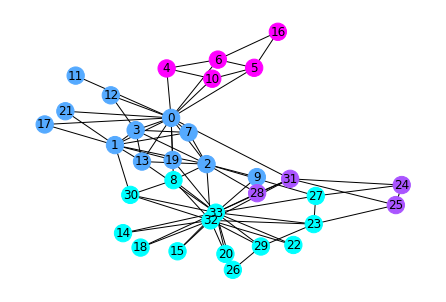

In [15]:
def get_pos(edge_index = data.edge_index, y = data.y, n = data.num_nodes):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G)
    
    return pos

def draw_graph(edge_index = data.edge_index, y = data.y, n = data.num_nodes, pos = None):
    # Create a random graph
    #edge_index = data.edge_index

    # Convert the edge index to a NetworkX graph
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    edges = edge_index.t().tolist()
    G.add_edges_from(edges)

    # Plot the graph
    if pos is None:
        pos = nx.spring_layout(G)
        #pos = nx.random_layout(G)
        #pos = nx.spectral_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=y.tolist(), cmap=plt.cm.get_cmap('cool', max(y)+1))
    plt.show()

draw_graph(data.edge_index, data.y, data.num_nodes)

In [16]:
def update_adjacency_matrix(A, k=10):
    
#     A = np.array([[0, 1, 0, 1],
#                        [1, 0, 1, 0],
#                        [0, 1, 0, 1],
#                        [1, 0, 1, 0]])

    # Compute the eigenvalues and eigenvectors of A
    eigvals, eigvecs = linalg.eig(A)

    # Remove the zero eigenvalue and its corresponding eigenvector
    nonzero_eigvals = eigvals[eigvals != 0]
    nonzero_eigvecs = eigvecs[:, eigvals != 0]

    # Sort the nonzero eigenvalues and eigenvectors in ascending order
    sorted_indices = np.argsort(nonzero_eigvals)
    sorted_eigvals = nonzero_eigvals[sorted_indices]
    sorted_eigvecs = nonzero_eigvecs[:, sorted_indices]

    # Find the top k smallest and largest nonzero eigenvalues and eigenvectors
    smallest_eigvals = sorted_eigvals[:k]
    smallest_eigvecs = sorted_eigvecs[:, :k]
    largest_eigvals = sorted_eigvals[-k:]
    largest_eigvecs = sorted_eigvecs[:, -k:]

    # Print the results
    print("The top", k, "smallest nonzero eigenvalues are:")
    print(smallest_eigvals)
    print("The corresponding eigenvectors are:")
    print(smallest_eigvecs)
    print("The top", k, "largest nonzero eigenvalues are:")
    print(largest_eigvals)
    print("The corresponding eigenvectors are:")
    print(largest_eigvecs)

#     # Generate the updated adjacency matrix by adding the smallest and largest eigenvectors as new rows and columns
#     updated_A = np.block([[A, smallest_eigvecs, largest_eigvecs],
#                           [smallest_eigvecs.T, np.zeros((k, k)), np.zeros((k, k))],
#                           [largest_eigvecs.T, np.zeros((k, k)), np.zeros((k, k))]])
    # Construct the updated adjacency matrix
#     updated_A = np.matmul(largest_eigvecs, np.matmul(np.diag(largest_eigvals), np.transpose(largest_eigvecs)))
    #updated_A += np.matmul(smallest_eigvecs, np.matmul(np.diag(smallest_eigvals), np.transpose(smallest_eigvecs)))
    updated_A = np.matmul(smallest_eigvecs, np.matmul(np.diag(smallest_eigvals), np.transpose(smallest_eigvecs)))


    # Print the updated adjacency matrix
    print("The updated adjacency matrix is:")
    print(updated_A)
    
    return updated_A

In [17]:
adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
edges = data.edge_index.t()
adj_mat[edges[:,0], edges[:,1]] = 1



In [18]:
adj2 = update_adjacency_matrix(adj_mat, k=5)
adj2.shape

The top 5 smallest nonzero eigenvalues are:
[-4.4872303+0.j -3.4479363+0.j -3.1106954+0.j -2.4374232+0.j
 -2.0908244+0.j]
The corresponding eigenvectors are:
[[-3.17170262e-01+0.j  2.77299166e-01+0.j  5.54685771e-01+0.j
  -1.71391606e-01+0.j  1.87498028e-03+0.j]
 [-1.24961369e-01+0.j  1.07877426e-01+0.j  1.70376934e-02+0.j
   6.65422916e-01+0.j -4.15284410e-02+0.j]
 [-2.72615869e-02+0.j -5.39242685e-01+0.j  1.33276999e-01+0.j
  -1.06188521e-01+0.j  7.66134262e-02+0.j]
 [ 1.92223843e-02+0.j  1.99072789e-02+0.j -5.44906482e-02+0.j
  -9.63859484e-02+0.j  6.46598637e-02+0.j]
 [ 4.80742343e-02+0.j -4.90778200e-02+0.j -1.03269607e-01+0.j
   3.46602090e-02+0.j -3.80217563e-04+0.j]
 [ 5.33759892e-02+0.j -5.90042919e-02+0.j -1.30175412e-01+0.j
   5.22494391e-02+0.j -7.00872450e-04+0.j]
 [ 5.33759892e-02+0.j -5.90043105e-02+0.j -1.30175307e-01+0.j
   5.22497296e-02+0.j -7.00248464e-04+0.j]
 [ 1.00322634e-01+0.j  3.89100313e-02+0.j -2.09120661e-01+0.j
  -1.19576015e-01+0.j -4.86032218e-02+0.j]
 [

(34, 34)

(34, 34)
108
156
108


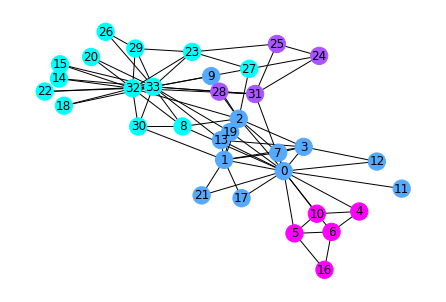

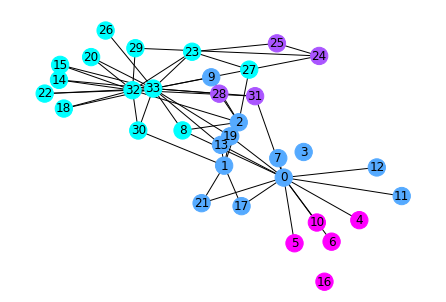

In [19]:
adj3 = (adj2>0.30).astype(int)

print(adj3.shape)

edges = adj3.nonzero()

print(len(edges[0]))
edge_index = torch.LongTensor([edges[0],edges[1]])
edge_index, _ = remove_self_loops(edge_index)

print(len(data.edge_index[0]))
print(len(edge_index[0]))
#print(edge_index)

pos  = get_pos()
draw_graph(data.edge_index, data.y, data.num_nodes,pos)
draw_graph(edge_index, data.y, data.num_nodes, pos)

In [20]:
import networkx as nx

# Define a graph
G = nx.Graph()
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)])

# Compute the k-max cover of the graph
k = 2

#cover = nx.algorithms.approximation.vertex_cover.min_weighted_vertex_cover(G, weight=lambda x: 1)


In [21]:
# create a graph with 10 nodes and 20 edges
G = nx.gnm_random_graph(10, 20)
# find the 3-core of the graph
C = nx.k_core(G, k=3)
# print the nodes and edges of the core
print(C.nodes())
print(C.edges())

[0, 1, 2, 3, 4, 5, 7, 9]
[(0, 3), (0, 1), (0, 5), (0, 7), (1, 9), (1, 4), (1, 2), (2, 5), (2, 9), (2, 4), (3, 5), (3, 7), (3, 9), (4, 9), (5, 7), (7, 9)]


In [22]:
# nn = NearestNeighbors(n_neighbors=2, metric="cosine")
# nn.fit(data.x)
# distances, indices = nn.kneighbors(data.x)


In [23]:
# u = []
# v = []

# # Loop through each row of indices and distances
# for i in range(len(indices)):
#     # Loop through each neighbor index and distance
#     for j in range(len(indices[i])):
#         # Skip the self-loop edge
#         if i == indices[i][j]:
#             continue
#         u.append(i)
#         v.append(indices[i][j])

In [24]:
# edge_index = torch.LongTensor([u,v])
# data.edge_index = edge_index
# edge_index.shape

In [25]:
# file_path = '/scratch/gilbreth/das90/Dataset/heterophily/graphsaintrandomwalksampler_2_100.pt'
# if os.path.exists(file_path):
#     !rm '/scratch/gilbreth/das90/Dataset/heterophily/graphsaintrandomwalksampler_2_100.pt'
#     None

In [26]:
# model  = GSAINTperformance(data, dataset, epochs=50)

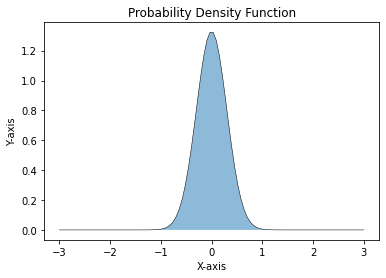

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

mu, sigma = 0, 0.3 # mean and standard deviation
x = np.linspace(-3, 3, 100)
y = norm.pdf(x, mu, sigma)

fig, ax = plt.subplots()
ax.plot(x, y, 'k', linewidth=0.5)
ax.fill_between(x, y, where=(x > -3) & (x < 3), alpha=0.5)
ax.set_title('Probability Density Function')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
plt.show()

# Observation

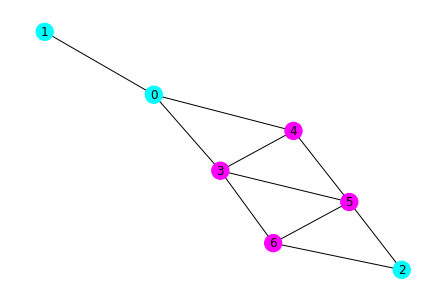

In [28]:
x = torch.Tensor([[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1]])
y = torch.LongTensor([0,0,0, 1, 1, 1, 1])
edge_index = torch.LongTensor([[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
edge_index = edge_index-1
data = Data(x=x, y=y, edge_index = edge_index)
draw_graph(edge_index, y, 7)

#### A simple GNN (One layer) is 

$Y = softmax(\hat A XW)$

$y\in R^{N\times C}, \hat A \in R^{N\times N}, X \in R^{N\times F} , W \in R^{F\times C}$

Here, $ \tilde A = A+I, \hat A = A_{rw} = \tilde D^{-1} \tilde A$

In terms of gradient descent, the update of $Y$ is,

$\Delta Y' \propto S(\hat A, X)(Z-Y)$


Here, $Z$ is the original label and $Y$ predicted


$S(\hat A, X) = \hat AX (\hat AX)^T $

$S(\hat A, X)$ can be considered as gram matrix, or pairwise node similarity after aggregation


#### 2 Layer GCN

$Y = softmax(\hat A_{sym} ReLU (\hat A_{sym}XW_0)W_1)$

### Laplacian and affinity (transition) matrices

$L = D - A$

$L_{sym} = D^{-1/2} L D^{-1/2}$

$L_{rw} = D^{-1} L = I - D^{-1} A$

$A_{rw} = I - L_{rw} = D^{-1} A $

$A_{sym} = I-L_{sym} =  D^{-1/2} A D^{-1/2}$

$\tilde A = A + I$

Hat is when $\tilde A$ is used, self loop

#### High pass filters: Sharpen 
$L_{sym}, L_{rw}, \hat L_{sym}, \hat L_{rw}$

#### Low pass filters: Smoothen

$A_{sym}, A_{rw}, \hat A_{sym}, \hat A_{rw}$

In [29]:
A = torch.zeros((7,7))
edges = data.edge_index.t()
A[edges[:,0], edges[:,1]] = 1
I = torch.eye(7)
D = torch.diag(torch.Tensor(torch.sum(A,dim=1)))
print(A)
print(D)

tensor([[0., 1., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1., 0.]])
tensor([[3., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 4., 0., 0., 0.],
        [0., 0., 0., 0., 3., 0., 0.],
        [0., 0., 0., 0., 0., 4., 0.],
        [0., 0., 0., 0., 0., 0., 3.]])


### Lets assume our Feature X is the label Z

In [30]:
# AX = torch.mm(A,x)
# print(AX)
# torch.mm(AX,AX.T)

In [31]:
Ai = A + I
DiInv = torch.diag(torch.Tensor(1/torch.sum(Ai,dim=1)))
Arw = torch.mm(DiInv, Ai)
Arw

tensor([[0.2500, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333],
        [0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000],
        [0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.2500]])

In [32]:
AX = torch.mm(Arw,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[0.5000, 0.5000],
        [1.0000, 0.0000],
        [0.3333, 0.6667],
        [0.2000, 0.8000],
        [0.2500, 0.7500],
        [0.2000, 0.8000],
        [0.2500, 0.7500]])


tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 1.0000, 0.3333, 0.2000, 0.2500, 0.2000, 0.2500],
        [0.5000, 0.3333, 0.5556, 0.6000, 0.5833, 0.6000, 0.5833],
        [0.5000, 0.2000, 0.6000, 0.6800, 0.6500, 0.6800, 0.6500],
        [0.5000, 0.2500, 0.5833, 0.6500, 0.6250, 0.6500, 0.6250],
        [0.5000, 0.2000, 0.6000, 0.6800, 0.6500, 0.6800, 0.6500],
        [0.5000, 0.2500, 0.5833, 0.6500, 0.6250, 0.6500, 0.6250]])

In [33]:
Arw

tensor([[0.2500, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333],
        [0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000],
        [0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.2500]])

In [34]:
I-Arw

tensor([[ 0.7500, -0.2500,  0.0000, -0.2500, -0.2500,  0.0000,  0.0000],
        [-0.5000,  0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.6667,  0.0000,  0.0000, -0.3333, -0.3333],
        [-0.2000,  0.0000,  0.0000,  0.8000, -0.2000, -0.2000, -0.2000],
        [-0.2500,  0.0000,  0.0000, -0.2500,  0.7500, -0.2500,  0.0000],
        [ 0.0000,  0.0000, -0.2000, -0.2000, -0.2000,  0.8000, -0.2000],
        [ 0.0000,  0.0000, -0.2500, -0.2500,  0.0000, -0.2500,  0.7500]])

In [35]:
AX = torch.mm(I-Arw,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[ 0.5000, -0.5000],
        [ 0.0000,  0.0000],
        [ 0.6667, -0.6667],
        [-0.2000,  0.2000],
        [-0.2500,  0.2500],
        [-0.2000,  0.2000],
        [-0.2500,  0.2500]])


tensor([[ 0.5000,  0.0000,  0.6667, -0.2000, -0.2500, -0.2000, -0.2500],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.6667,  0.0000,  0.8889, -0.2667, -0.3333, -0.2667, -0.3333],
        [-0.2000,  0.0000, -0.2667,  0.0800,  0.1000,  0.0800,  0.1000],
        [-0.2500,  0.0000, -0.3333,  0.1000,  0.1250,  0.1000,  0.1250],
        [-0.2000,  0.0000, -0.2667,  0.0800,  0.1000,  0.0800,  0.1000],
        [-0.2500,  0.0000, -0.3333,  0.1000,  0.1250,  0.1000,  0.1250]])

### insights 

-- pairwise similarity after aggregation, average weights of the matching label neighbors if greater than 0 then that can be correctly classified

-- Negative weights can be considered during aggregation 

-- if the task involves information diffusion or propagation, the transition matrix may be more suitable. On the other hand, if the task involves smooth feature transformations or graph clustering, the graph Laplacian matrix may be more appropriate


-- (Spatial) Affinity associates with aggregation (K-NN samples) 

-- (Spectral) Laplacian associates with diversification (Submodular Samples) 

-- Identity: ignore the neighborhood, decision based on current node feature only

-- For each node, get three representation , combine and make decision based on this

*** the Laplacian matrix L ensures that the feature update is based on the difference between the node's value and the average value of its neighbors, which promotes smoothness and consistency across the graph.

-- low-pass filters mainly retain the commonality of node features, while high-pass filters
capture the difference between nodes.


Notes:

Survey on heterophilic graphs: https://arxiv.org/pdf/2202.07082.pdf

Revisiting graph with heterophily: https://arxiv.org/pdf/2210.07606.pdf

In [36]:
print(torch.var(x))
print(torch.var(torch.mm(A,x)))
print(torch.var(torch.mm(Arw,x)))
print(torch.var(torch.mm(I-Arw,x)))

tensor(0.2692)
tensor(0.8791)
tensor(0.0897)
tensor(0.1384)


In [37]:
X_s = torch.Tensor([1,2,3,4,5,6,7]).view(-1,1)

print(torch.var(X_s))
print(torch.var(torch.mm(A,X_s)))
print(torch.var(torch.mm(Arw,X_s)))
print(torch.var(torch.mm(I-Arw,X_s)))

tensor(4.6667)
tensor(36.9524)
tensor(1.8935)
tensor(2.6713)


In [38]:
x = torch.Tensor([[1,-1],[1,-1],[1,-1],[-1,1],[-1,1],[-1,1],[-1,1]])

In [39]:
AX = torch.mm(Arw,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[ 0.0000,  0.0000],
        [ 1.0000, -1.0000],
        [-0.3333,  0.3333],
        [-0.6000,  0.6000],
        [-0.5000,  0.5000],
        [-0.6000,  0.6000],
        [-0.5000,  0.5000]])


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.0000, -0.6667, -1.2000, -1.0000, -1.2000, -1.0000],
        [ 0.0000, -0.6667,  0.2222,  0.4000,  0.3333,  0.4000,  0.3333],
        [ 0.0000, -1.2000,  0.4000,  0.7200,  0.6000,  0.7200,  0.6000],
        [ 0.0000, -1.0000,  0.3333,  0.6000,  0.5000,  0.6000,  0.5000],
        [ 0.0000, -1.2000,  0.4000,  0.7200,  0.6000,  0.7200,  0.6000],
        [ 0.0000, -1.0000,  0.3333,  0.6000,  0.5000,  0.6000,  0.5000]])

In [40]:
AX = torch.mm(I-Arw,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[ 1.0000, -1.0000],
        [ 0.0000,  0.0000],
        [ 1.3333, -1.3333],
        [-0.4000,  0.4000],
        [-0.5000,  0.5000],
        [-0.4000,  0.4000],
        [-0.5000,  0.5000]])


tensor([[ 2.0000,  0.0000,  2.6667, -0.8000, -1.0000, -0.8000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 2.6667,  0.0000,  3.5556, -1.0667, -1.3333, -1.0667, -1.3333],
        [-0.8000,  0.0000, -1.0667,  0.3200,  0.4000,  0.3200,  0.4000],
        [-1.0000,  0.0000, -1.3333,  0.4000,  0.5000,  0.4000,  0.5000],
        [-0.8000,  0.0000, -1.0667,  0.3200,  0.4000,  0.3200,  0.4000],
        [-1.0000,  0.0000, -1.3333,  0.4000,  0.5000,  0.4000,  0.5000]])

In [41]:
Dhalf = torch.diag(torch.Tensor(1/torch.sqrt(torch.sum(Ai,dim=1))))
Ahat = torch.mm(torch.mm(Dhalf,Ai),Dhalf)
Ahat

tensor([[0.2500, 0.3536, 0.0000, 0.2236, 0.2500, 0.0000, 0.0000],
        [0.3536, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.2582, 0.2887],
        [0.2236, 0.0000, 0.0000, 0.2000, 0.2236, 0.2000, 0.2236],
        [0.2500, 0.0000, 0.0000, 0.2236, 0.2500, 0.2236, 0.0000],
        [0.0000, 0.0000, 0.2582, 0.2000, 0.2236, 0.2000, 0.2236],
        [0.0000, 0.0000, 0.2887, 0.2236, 0.0000, 0.2236, 0.2500]])

In [42]:
I-Ahat

tensor([[ 0.7500, -0.3536,  0.0000, -0.2236, -0.2500,  0.0000,  0.0000],
        [-0.3536,  0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.6667,  0.0000,  0.0000, -0.2582, -0.2887],
        [-0.2236,  0.0000,  0.0000,  0.8000, -0.2236, -0.2000, -0.2236],
        [-0.2500,  0.0000,  0.0000, -0.2236,  0.7500, -0.2236,  0.0000],
        [ 0.0000,  0.0000, -0.2582, -0.2000, -0.2236,  0.8000, -0.2236],
        [ 0.0000,  0.0000, -0.2887, -0.2236,  0.0000, -0.2236,  0.7500]])

In [43]:
AX = torch.mm(Ahat,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[ 0.1299, -0.1299],
        [ 0.8536, -0.8536],
        [-0.2135,  0.2135],
        [-0.6236,  0.6236],
        [-0.4472,  0.4472],
        [-0.5890,  0.5890],
        [-0.4085,  0.4085]])


tensor([[ 0.0338,  0.2218, -0.0555, -0.1621, -0.1162, -0.1531, -0.1062],
        [ 0.2218,  1.4571, -0.3645, -1.0646, -0.7634, -1.0055, -0.6974],
        [-0.0555, -0.3645,  0.0912,  0.2663,  0.1910,  0.2516,  0.1745],
        [-0.1621, -1.0646,  0.2663,  0.7778,  0.5578,  0.7346,  0.5095],
        [-0.1162, -0.7634,  0.1910,  0.5578,  0.4000,  0.5268,  0.3654],
        [-0.1531, -1.0055,  0.2516,  0.7346,  0.5268,  0.6939,  0.4813],
        [-0.1062, -0.6974,  0.1745,  0.5095,  0.3654,  0.4813,  0.3338]])

In [44]:
AX = torch.mm(I-Ahat,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[ 0.8701, -0.8701],
        [ 0.1464, -0.1464],
        [ 1.2135, -1.2135],
        [-0.3764,  0.3764],
        [-0.5528,  0.5528],
        [-0.4110,  0.4110],
        [-0.5915,  0.5915]])


tensor([[ 1.5140,  0.2548,  2.1117, -0.6550, -0.9619, -0.7152, -1.0292],
        [ 0.2548,  0.0429,  0.3554, -0.1102, -0.1619, -0.1204, -0.1732],
        [ 2.1117,  0.3554,  2.9454, -0.9135, -1.3417, -0.9975, -1.4355],
        [-0.6550, -0.1102, -0.9135,  0.2833,  0.4161,  0.3094,  0.4452],
        [-0.9619, -0.1619, -1.3417,  0.4161,  0.6111,  0.4544,  0.6539],
        [-0.7152, -0.1204, -0.9975,  0.3094,  0.4544,  0.3378,  0.4862],
        [-1.0292, -0.1732, -1.4355,  0.4452,  0.6539,  0.4862,  0.6997]])

In [45]:
W = torch.rand(2,2)
W

tensor([[0.0294, 0.5328],
        [0.2433, 0.4031]])

In [46]:
torch.mm(x,W)

tensor([[-0.2139,  0.1297],
        [-0.2139,  0.1297],
        [-0.2139,  0.1297],
        [ 0.2139, -0.1297],
        [ 0.2139, -0.1297],
        [ 0.2139, -0.1297],
        [ 0.2139, -0.1297]])

In [47]:
L = D-A 

y_lp = torch.mm(I-Arw,y.view(-1,1).type(torch.float))
y_lp

tensor([[-0.5000],
        [ 0.0000],
        [-0.6667],
        [ 0.2000],
        [ 0.2500],
        [ 0.2000],
        [ 0.2500]])

In [48]:
y_org_var = torch.var(y.type(torch.float))
print(y_org_var)

y_lp_var = torch.var(y_lp)
print(y_lp_var)

tensor(0.2857)
tensor(0.1482)


In [49]:
x_org = torch.var(x)
print(x_org)
x_lp = torch.var(torch.mm(I-Arw,x))
print(x_lp)
x_hp = torch.var(torch.mm(Arw,x))
print(x_hp)

tensor(1.0769)
tensor(0.5535)
tensor(0.3586)


In [50]:
L  = D - A

In [51]:
AX = torch.mm(L,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[ 4., -4.],
        [ 0.,  0.],
        [ 4., -4.],
        [-2.,  2.],
        [-2.,  2.],
        [-2.,  2.],
        [-2.,  2.]])


tensor([[ 32.,   0.,  32., -16., -16., -16., -16.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 32.,   0.,  32., -16., -16., -16., -16.],
        [-16.,   0., -16.,   8.,   8.,   8.,   8.],
        [-16.,   0., -16.,   8.,   8.,   8.,   8.],
        [-16.,   0., -16.,   8.,   8.,   8.,   8.],
        [-16.,   0., -16.,   8.,   8.,   8.,   8.]])

In [52]:
AX = torch.mm(A,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[-1.,  1.],
        [ 1., -1.],
        [-2.,  2.],
        [-2.,  2.],
        [-1.,  1.],
        [-2.,  2.],
        [-1.,  1.]])


tensor([[ 2., -2.,  4.,  4.,  2.,  4.,  2.],
        [-2.,  2., -4., -4., -2., -4., -2.],
        [ 4., -4.,  8.,  8.,  4.,  8.,  4.],
        [ 4., -4.,  8.,  8.,  4.,  8.,  4.],
        [ 2., -2.,  4.,  4.,  2.,  4.,  2.],
        [ 4., -4.,  8.,  8.,  4.,  8.,  4.],
        [ 2., -2.,  4.,  4.,  2.,  4.,  2.]])

In [53]:
Arw

tensor([[0.2500, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333],
        [0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000],
        [0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.2500]])

In [54]:
I-Arw

tensor([[ 0.7500, -0.2500,  0.0000, -0.2500, -0.2500,  0.0000,  0.0000],
        [-0.5000,  0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.6667,  0.0000,  0.0000, -0.3333, -0.3333],
        [-0.2000,  0.0000,  0.0000,  0.8000, -0.2000, -0.2000, -0.2000],
        [-0.2500,  0.0000,  0.0000, -0.2500,  0.7500, -0.2500,  0.0000],
        [ 0.0000,  0.0000, -0.2000, -0.2000, -0.2000,  0.8000, -0.2000],
        [ 0.0000,  0.0000, -0.2500, -0.2500,  0.0000, -0.2500,  0.7500]])

In [55]:
A


tensor([[0., 1., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 1., 1., 0., 1., 0.]])

In [56]:
Arw

tensor([[0.2500, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333],
        [0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.2500, 0.0000, 0.0000, 0.2500, 0.2500, 0.2500, 0.0000],
        [0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.2500, 0.2500, 0.0000, 0.2500, 0.2500]])

In [57]:
AX = torch.mm(I-Arw,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[ 1.0000, -1.0000],
        [ 0.0000,  0.0000],
        [ 1.3333, -1.3333],
        [-0.4000,  0.4000],
        [-0.5000,  0.5000],
        [-0.4000,  0.4000],
        [-0.5000,  0.5000]])


tensor([[ 2.0000,  0.0000,  2.6667, -0.8000, -1.0000, -0.8000, -1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 2.6667,  0.0000,  3.5556, -1.0667, -1.3333, -1.0667, -1.3333],
        [-0.8000,  0.0000, -1.0667,  0.3200,  0.4000,  0.3200,  0.4000],
        [-1.0000,  0.0000, -1.3333,  0.4000,  0.5000,  0.4000,  0.5000],
        [-0.8000,  0.0000, -1.0667,  0.3200,  0.4000,  0.3200,  0.4000],
        [-1.0000,  0.0000, -1.3333,  0.4000,  0.5000,  0.4000,  0.5000]])

In [58]:
An = A
An[0,3]=-1
An[0,4]=-1
An[2,5]=-1
An[2,6]=-1
An[3,0]=-1
An[4,0]=-1
An[5,2]=-1
An[6,2]=-1
An

tensor([[ 0.,  1.,  0., -1., -1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1., -1.],
        [-1.,  0.,  0.,  0.,  1.,  1.,  1.],
        [-1.,  0.,  0.,  1.,  0.,  1.,  0.],
        [ 0.,  0., -1.,  1.,  1.,  0.,  1.],
        [ 0.,  0., -1.,  1.,  0.,  1.,  0.]])

In [59]:
Anrw = torch.mm(DiInv,An)
Anrw

tensor([[ 0.0000,  0.2500,  0.0000, -0.2500, -0.2500,  0.0000,  0.0000],
        [ 0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.3333, -0.3333],
        [-0.2000,  0.0000,  0.0000,  0.0000,  0.2000,  0.2000,  0.2000],
        [-0.2500,  0.0000,  0.0000,  0.2500,  0.0000,  0.2500,  0.0000],
        [ 0.0000,  0.0000, -0.2000,  0.2000,  0.2000,  0.0000,  0.2000],
        [ 0.0000,  0.0000, -0.2500,  0.2500,  0.0000,  0.2500,  0.0000]])

In [60]:
AX = torch.mm(Anrw,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[ 0.7500, -0.7500],
        [ 0.5000, -0.5000],
        [ 0.6667, -0.6667],
        [-0.8000,  0.8000],
        [-0.7500,  0.7500],
        [-0.8000,  0.8000],
        [-0.7500,  0.7500]])


tensor([[ 1.1250,  0.7500,  1.0000, -1.2000, -1.1250, -1.2000, -1.1250],
        [ 0.7500,  0.5000,  0.6667, -0.8000, -0.7500, -0.8000, -0.7500],
        [ 1.0000,  0.6667,  0.8889, -1.0667, -1.0000, -1.0667, -1.0000],
        [-1.2000, -0.8000, -1.0667,  1.2800,  1.2000,  1.2800,  1.2000],
        [-1.1250, -0.7500, -1.0000,  1.2000,  1.1250,  1.2000,  1.1250],
        [-1.2000, -0.8000, -1.0667,  1.2800,  1.2000,  1.2800,  1.2000],
        [-1.1250, -0.7500, -1.0000,  1.2000,  1.1250,  1.2000,  1.1250]])

In [61]:
AX = torch.mm(I-Anrw,x)
print(AX)
torch.mm(AX,AX.T)

tensor([[ 0.2500, -0.2500],
        [ 0.5000, -0.5000],
        [ 0.3333, -0.3333],
        [-0.2000,  0.2000],
        [-0.2500,  0.2500],
        [-0.2000,  0.2000],
        [-0.2500,  0.2500]])


tensor([[ 0.1250,  0.2500,  0.1667, -0.1000, -0.1250, -0.1000, -0.1250],
        [ 0.2500,  0.5000,  0.3333, -0.2000, -0.2500, -0.2000, -0.2500],
        [ 0.1667,  0.3333,  0.2222, -0.1333, -0.1667, -0.1333, -0.1667],
        [-0.1000, -0.2000, -0.1333,  0.0800,  0.1000,  0.0800,  0.1000],
        [-0.1250, -0.2500, -0.1667,  0.1000,  0.1250,  0.1000,  0.1250],
        [-0.1000, -0.2000, -0.1333,  0.0800,  0.1000,  0.0800,  0.1000],
        [-0.1250, -0.2500, -0.1667,  0.1000,  0.1250,  0.1000,  0.1250]])

In [62]:
A

tensor([[ 0.,  1.,  0., -1., -1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1., -1.],
        [-1.,  0.,  0.,  0.,  1.,  1.,  1.],
        [-1.,  0.,  0.,  1.,  0.,  1.,  0.],
        [ 0.,  0., -1.,  1.,  1.,  0.,  1.],
        [ 0.,  0., -1.,  1.,  0.,  1.,  0.]])

# I-Arw

In [63]:
x = torch.Tensor([[1,0,1],[1,0,1],[1,0,1],[0,1,1],[0,1,1],[0,1,1],[0,1,1],[0,1,1]])
#x = torch.Tensor([0,0,0,1,1,1,1]).view(-1,1)
y = torch.LongTensor([0,0,0, 1, 1, 1, 1,1])
edge_index = torch.LongTensor([[8,5],[8,7],[7,8],[5,8],[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
edge_index = edge_index-1
data = Data(x=x, y=y, edge_index = edge_index)

In [68]:
A = torch.zeros((8,8))
edges = data.edge_index.t()
A[edges[:,0], edges[:,1]] = 1
I = torch.eye(8)
D = torch.diag(torch.Tensor(torch.sum(A,dim=1)))
# print(A)
# print(D)

Ai = A + I
DiInv = torch.diag(torch.Tensor(1/torch.sum(Ai,dim=1)))
Arw = torch.mm(DiInv, Ai)
Arw

tensor([[0.2500, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000],
        [0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.0000, 0.2000],
        [0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333]])

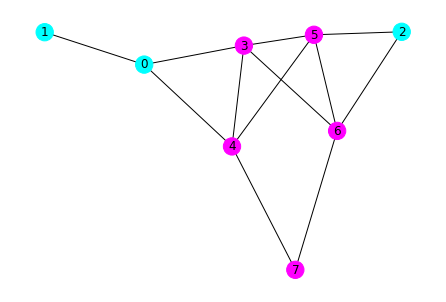

In [69]:
draw_graph(edge_index, y, 8)

In [70]:
I-Arw

tensor([[ 0.7500, -0.2500,  0.0000, -0.2500, -0.2500,  0.0000,  0.0000,  0.0000],
        [-0.5000,  0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.6667,  0.0000,  0.0000, -0.3333, -0.3333,  0.0000],
        [-0.2000,  0.0000,  0.0000,  0.8000, -0.2000, -0.2000, -0.2000,  0.0000],
        [-0.2000,  0.0000,  0.0000, -0.2000,  0.8000, -0.2000,  0.0000, -0.2000],
        [ 0.0000,  0.0000, -0.2000, -0.2000, -0.2000,  0.8000, -0.2000,  0.0000],
        [ 0.0000,  0.0000, -0.2000, -0.2000,  0.0000, -0.2000,  0.8000, -0.2000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.3333,  0.0000, -0.3333,  0.6667]])

In [79]:
#torch.set_printoptions(sci_mode=False)
AX = torch.mm(I-Arw,x)
print(AX)
print(torch.mm(AX,AX.T))

tensor([[     0.5000,     -0.5000,      0.0000],
        [     0.0000,      0.0000,      0.0000],
        [     0.6667,     -0.6667,     -0.0000],
        [    -0.2000,      0.2000,      0.0000],
        [    -0.2000,      0.2000,      0.0000],
        [    -0.2000,      0.2000,     -0.0000],
        [    -0.2000,      0.2000,     -0.0000],
        [     0.0000,     -0.0000,     -0.0000]])
tensor([[     0.5000,      0.0000,      0.6667,     -0.2000,     -0.2000,
             -0.2000,     -0.2000,      0.0000],
        [     0.0000,      0.0000,      0.0000,      0.0000,      0.0000,
              0.0000,      0.0000,      0.0000],
        [     0.6667,      0.0000,      0.8889,     -0.2667,     -0.2667,
             -0.2667,     -0.2667,      0.0000],
        [    -0.2000,      0.0000,     -0.2667,      0.0800,      0.0800,
              0.0800,      0.0800,     -0.0000],
        [    -0.2000,      0.0000,     -0.2667,      0.0800,      0.0800,
              0.0800,      0.0800,     -0

In [75]:
Arw

tensor([[0.2500, 0.2500, 0.0000, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3333, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000],
        [0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.2000, 0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.0000, 0.2000],
        [0.0000, 0.0000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.2000, 0.2000, 0.0000, 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.0000, 0.3333, 0.3333]])

In [80]:
AX = torch.mm(Arw,x)
print(AX)
print(torch.mm(AX,AX.T))

tensor([[0.5000, 0.5000, 1.0000],
        [1.0000, 0.0000, 1.0000],
        [0.3333, 0.6667, 1.0000],
        [0.2000, 0.8000, 1.0000],
        [0.2000, 0.8000, 1.0000],
        [0.2000, 0.8000, 1.0000],
        [0.2000, 0.8000, 1.0000],
        [0.0000, 1.0000, 1.0000]])
tensor([[1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
        [1.5000, 2.0000, 1.3333, 1.2000, 1.2000, 1.2000, 1.2000, 1.0000],
        [1.5000, 1.3333, 1.5556, 1.6000, 1.6000, 1.6000, 1.6000, 1.6667],
        [1.5000, 1.2000, 1.6000, 1.6800, 1.6800, 1.6800, 1.6800, 1.8000],
        [1.5000, 1.2000, 1.6000, 1.6800, 1.6800, 1.6800, 1.6800, 1.8000],
        [1.5000, 1.2000, 1.6000, 1.6800, 1.6800, 1.6800, 1.6800, 1.8000],
        [1.5000, 1.2000, 1.6000, 1.6800, 1.6800, 1.6800, 1.6800, 1.8000],
        [1.5000, 1.0000, 1.6667, 1.8000, 1.8000, 1.8000, 1.8000, 2.0000]])


In [ ]:
#x = torch.Tensor([[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1]])
x = torch.Tensor([0,0,0,1,1,1,1]).view(-1,1)
y = torch.LongTensor([0,0,0, 1, 1, 1, 1])
edge_index = torch.LongTensor([[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
edge_index = edge_index-1
data = Data(x=x, y=y, edge_index = edge_index)

In [ ]:
draw_graph(edge_index, y, 7)